In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [34]:
class Attention(nn.Module):
    def __init__(
        self,
        channels,
        num_heads,
        proj_drop=0.0,
        kernel_size=3,
        stride_kv=1,
        stride_q=1,
        padding_kv="same",
        padding_q="same",
        attention_bias=True,
    ):
        super().__init__()
        self.stride_kv = stride_kv
        self.stride_q = stride_q
        self.num_heads = num_heads
        self.proj_drop = proj_drop

        self.conv_q = nn.Conv2d(
            channels,
            channels,
            kernel_size,
            stride_q,
            padding_q,
            bias=attention_bias,
            groups=channels,
        )
        self.layernorm_q = nn.LayerNorm(channels, eps=1e-5)
        self.conv_k = nn.Conv2d(
            channels,
            channels,
            kernel_size,
            stride_kv,
            stride_kv,
            bias=attention_bias,
            groups=channels,
        )
        self.layernorm_k = nn.LayerNorm(channels, eps=1e-5)
        self.conv_v = nn.Conv2d(
            channels,
            channels,
            kernel_size,
            stride_kv,
            stride_kv,
            bias=attention_bias,
            groups=channels,
        )
        self.layernorm_v = nn.LayerNorm(channels, eps=1e-5)

        self.attention = nn.MultiheadAttention(
            embed_dim=channels,
            bias=attention_bias,
            batch_first=True,
            # dropout = 0.0,
            num_heads=1,
        )  # num_heads=self.num_heads)

    def _build_projection(self, x, qkv):
        if qkv == "q":
            x1 = F.relu(self.conv_q(x))
            x1 = x1.permute(0, 2, 3, 1)
            x1 = self.layernorm_q(x1)
            proj = x1.permute(0, 3, 1, 2)
        elif qkv == "k":
            x1 = F.relu(self.conv_k(x))
            x1 = x1.permute(0, 2, 3, 1)
            x1 = self.layernorm_k(x1)
            proj = x1.permute(0, 3, 1, 2)
        elif qkv == "v":
            x1 = F.relu(self.conv_v(x))
            x1 = x1.permute(0, 2, 3, 1)
            x1 = self.layernorm_v(x1)
            proj = x1.permute(0, 3, 1, 2)

        return proj

    def forward_conv(self, x):
        q = self._build_projection(x, "q")
        k = self._build_projection(x, "k")
        v = self._build_projection(x, "v")

        return q, k, v

    def forward(self, x):
        q, k, v = self.forward_conv(x)
        q = q.view(x.shape[0], x.shape[1], x.shape[2] * x.shape[3])
        k = k.view(x.shape[0], x.shape[1], x.shape[2] * x.shape[3])
        v = v.view(x.shape[0], x.shape[1], x.shape[2] * x.shape[3])
        q = q.permute(0, 2, 1)
        k = k.permute(0, 2, 1)
        v = v.permute(0, 2, 1)
        x1 = self.attention(query=q, value=v, key=k, need_weights=False)

        x1 = x1[0].permute(0, 2, 1)
        x1 = x1.view(
            x1.shape[0],
            x1.shape[1],
            np.sqrt(x1.shape[2]).astype(int),
            np.sqrt(x1.shape[2]).astype(int),
        )
        x1 = F.dropout(x1, self.proj_drop)

        return x1


class Transformer(nn.Module):
    def __init__(
        self,
        # in_channels,
        out_channels,
        num_heads,
        dpr,
        proj_drop=0.0,
        attention_bias=True,
        padding_q="same",
        padding_kv="same",
        stride_kv=1,
        stride_q=1,
    ):
        super().__init__()

        self.attention_output = Attention(
            channels=out_channels,
            num_heads=num_heads,
            proj_drop=proj_drop,
            padding_q=padding_q,
            padding_kv=padding_kv,
            stride_kv=stride_kv,
            stride_q=stride_q,
            attention_bias=attention_bias,
        )

        self.conv1 = nn.Conv2d(out_channels, out_channels, 3, 1, padding="same")
        self.layernorm = nn.LayerNorm(self.conv1.out_channels, eps=1e-5)
        self.wide_focus = Wide_Focus(out_channels, out_channels)

    def forward(self, x):
        x1 = self.attention_output(x)
        x1 = self.conv1(x1)
        x2 = torch.add(x1, x)
        x3 = x2.permute(0, 2, 3, 1)
        x3 = self.layernorm(x3)
        x3 = x3.permute(0, 3, 1, 2)
        x3 = self.wide_focus(x3)
        x3 = torch.add(x2, x3)
        return x3

        return x


class Wide_Focus(nn.Module):
    """
    Wide-Focus module.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, padding="same")
        self.conv2 = nn.Conv2d(
            in_channels, out_channels, 3, 1, padding="same", dilation=2
        )
        self.conv3 = nn.Conv2d(
            in_channels, out_channels, 3, 1, padding="same", dilation=3
        )
        self.conv4 = nn.Conv2d(in_channels, out_channels, 3, 1, padding="same")

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = F.gelu(x1)
        x1 = F.dropout(x1, 0.1)
        x2 = self.conv2(x)
        x2 = F.gelu(x2)
        x2 = F.dropout(x2, 0.1)
        x3 = self.conv3(x)
        x3 = F.gelu(x3)
        x3 = F.dropout(x3, 0.1)
        added = torch.add(x1, x2)
        added = torch.add(added, x3)
        x_out = self.conv4(added)
        x_out = F.gelu(x_out)
        x_out = F.dropout(x_out, 0.1)
        return x_out


class Block_encoder_bottleneck(nn.Module):
    def __init__(self, blk, in_channels, out_channels, att_heads, dpr):
        super().__init__()
        self.blk = blk
        if (self.blk == "first") or (self.blk == "bottleneck"):
            self.layernorm = nn.LayerNorm(in_channels, eps=1e-5)
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, padding="same")
            self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding="same")
            self.trans = Transformer(out_channels, att_heads, dpr)
        elif (self.blk == "second") or (self.blk == "third") or (self.blk == "fourth"):
            self.layernorm = nn.LayerNorm(in_channels, eps=1e-5)
            self.conv1 = nn.Conv2d(1, in_channels, 3, 1, padding="same")
            self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding="same")
            self.conv3 = nn.Conv2d(out_channels, out_channels, 3, 1, padding="same")
            self.trans = Transformer(out_channels, att_heads, dpr)

    def forward(self, x, scale_img="none"):
        if (self.blk == "first") or (self.blk == "bottleneck"):
            x1 = x.permute(0, 2, 3, 1)
            x1 = self.layernorm(x1)
            x1 = x1.permute(0, 3, 1, 2)
            x1 = F.relu(self.conv1(x1))
            x1 = F.relu(self.conv2(x1))
            x1 = F.dropout(x1, 0.3)
            x1 = F.max_pool2d(x1, (2, 2))
            out = self.trans(x1)
            # without skip
        elif (self.blk == "second") or (self.blk == "third") or (self.blk == "fourth"):
            x1 = x.permute(0, 2, 3, 1)
            x1 = self.layernorm(x1)
            x1 = x1.permute(0, 3, 1, 2)
            x1 = torch.cat((F.relu(self.conv1(scale_img)), x1), axis=1)
            x1 = F.relu(self.conv2(x1))
            x1 = F.relu(self.conv3(x1))
            x1 = F.dropout(x1, 0.3)
            x1 = F.max_pool2d(x1, (2, 2))
            out = self.trans(x1)
            # with skip
        return out


class Block_decoder(nn.Module):
    def __init__(self, in_channels, out_channels, att_heads, dpr):
        super().__init__()
        self.layernorm = nn.LayerNorm(in_channels, eps=1e-5)
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, padding="same")
        self.conv2 = nn.Conv2d(out_channels * 2, out_channels, 3, 1, padding="same")
        self.conv3 = nn.Conv2d(out_channels, out_channels, 3, 1, padding="same")
        self.trans = Transformer(out_channels, att_heads, dpr)

    def forward(self, x, skip):
        x1 = x.permute(0, 2, 3, 1)
        x1 = self.layernorm(x1)
        x1 = x1.permute(0, 3, 1, 2)
        x1 = self.upsample(x1)
        x1 = F.relu(self.conv1(x1))
        x1 = torch.cat((skip, x1), axis=1)
        x1 = F.relu(self.conv2(x1))
        x1 = F.relu(self.conv3(x1))
        x1 = F.dropout(x1, 0.3)
        out = self.trans(x1)
        return out


class DS_out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.layernorm = nn.LayerNorm(in_channels, eps=1e-5)
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, 1, padding="same")
        self.conv2 = nn.Conv2d(in_channels, in_channels, 3, 1, padding="same")
        self.conv3 = nn.Conv2d(in_channels, out_channels, 3, 1, padding="same")

    def forward(self, x):
        x1 = self.upsample(x)
        x1 = x1.permute(0, 2, 3, 1)
        x1 = self.layernorm(x1)
        x1 = x1.permute(0, 3, 1, 2)
        x1 = F.relu(self.conv1(x1))
        x1 = F.relu(self.conv2(x1))
        out = torch.sigmoid(self.conv3(x1))

        return out


class FCT(nn.Module):
    def __init__(self):
        super().__init__()

        # attention heads and filters per block
        att_heads = [2, 2, 2, 2, 2, 2, 2, 2, 2]
        filters = [8, 16, 32, 64, 128, 64, 32, 16, 8]

        # number of blocks used in the model
        blocks = len(filters)

        stochastic_depth_rate = 0.0

        # probability for each block
        dpr = [x for x in np.linspace(0, stochastic_depth_rate, blocks)]

        self.drp_out = 0.3

        # shape
        # init_sizes = torch.ones((2,224,224,1))
        # init_sizes = init_sizes.permute(0, 3, 1, 2)

        # Multi-scale input
        self.scale_img = nn.AvgPool2d(2, 2)

        # model
        self.block_1 = Block_encoder_bottleneck(
            "first", 1, filters[0], att_heads[0], dpr[0]
        )
        self.block_2 = Block_encoder_bottleneck(
            "second", filters[0], filters[1], att_heads[1], dpr[1]
        )
        self.block_3 = Block_encoder_bottleneck(
            "third", filters[1], filters[2], att_heads[2], dpr[2]
        )
        self.block_4 = Block_encoder_bottleneck(
            "fourth", filters[2], filters[3], att_heads[3], dpr[3]
        )
        self.block_5 = Block_encoder_bottleneck(
            "bottleneck", filters[3], filters[4], att_heads[4], dpr[4]
        )
        self.block_6 = Block_decoder(filters[4], filters[5], att_heads[5], dpr[5])
        self.block_7 = Block_decoder(filters[5], filters[6], att_heads[6], dpr[6])
        self.block_8 = Block_decoder(filters[6], filters[7], att_heads[7], dpr[7])
        self.block_9 = Block_decoder(filters[7], filters[8], att_heads[8], dpr[8])

        self.ds7 = DS_out(filters[6], 4)
        self.ds8 = DS_out(filters[7], 4)
        self.ds9 = DS_out(filters[8], 4)

    def forward(self, x):
        # Multi-scale input
        scale_img_2 = self.scale_img(x)
        scale_img_3 = self.scale_img(scale_img_2)
        scale_img_4 = self.scale_img(scale_img_3)

        x = self.block_1(x)
        # print(f"Block 1 out -> {list(x.size())}")
        skip1 = x
        x = self.block_2(x, scale_img_2)
        # print(f"Block 2 out -> {list(x.size())}")
        skip2 = x
        x = self.block_3(x, scale_img_3)
        # print(f"Block 3 out -> {list(x.size())}")
        skip3 = x
        x = self.block_4(x, scale_img_4)
        # print(f"Block 4 out -> {list(x.size())}")
        skip4 = x
        x = self.block_5(x)
        # print(f"Block 5 out -> {list(x.size())}")
        x = self.block_6(x, skip4)
        # print(f"Block 6 out -> {list(x.size())}")
        x = self.block_7(x, skip3)
        # print(f"Block 7 out -> {list(x.size())}")
        skip7 = x
        x = self.block_8(x, skip2)
        # print(f"Block 8 out -> {list(x.size())}")
        skip8 = x
        x = self.block_9(x, skip1)
        # print(f"Block 9 out -> {list(x.size())}")
        skip9 = x

        out7 = self.ds7(skip7)
        # print(f"DS 7 out -> {list(out7.size())}")
        out8 = self.ds8(skip8)
        # print(f"DS 8 out -> {list(out8.size())}")
        out9 = self.ds9(skip9)
        # print(f"DS 9 out -> {list(out9.size())}")

        return out7, out8, out9


def init_weights(m):
    """
    Initialize the weights
    """
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

# Experiment Pipeline

In [35]:
import torch
import torch.optim as optim

from hubmap.experiments.load_data import make_expert_loader
from hubmap.experiments.load_data import make_annotated_loader
from hubmap.dataset import transforms as T
from hubmap.losses import BCEDiceLoss
from hubmap.metrics import IoU
from hubmap.training import train
from hubmap.training import LRScheduler
from hubmap.training import EarlyStopping

from hubmap.metrics import model_size

First we load the data that we need for the experiment. This includes the training data, the validation (test) data that we will use for training.

For this, depending on the experiments we use different transformations on the data. The following transformations are a minimal example. Furhter transformations should be included for more sophisticated experiments.

In [36]:
# MINIMUM SIZE OF IMAGES FOR MODEL INPUT IS 64x64
IMG_DIM = 64

In [37]:
train_transformations = T.Compose(
    [
        T.ToTensor(),
        T.Resize((IMG_DIM, IMG_DIM)),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

test_transformations = T.Compose(
    [
        T.ToTensor(),
        T.Resize((IMG_DIM, IMG_DIM)),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

Depending on the experiment we may want to load all annotated images or just the ones that are annotated by experts.

Here we create a function to load all the images that are annotated (not only the ones by experts).
The created function can than be used to load the data loaders with a specific batch size.

In [38]:
# The train, test split ratio is set to 0.8 by default.
# Meaning 80% of the data is used for training and 20% for testing.
load_annotated_data = make_annotated_loader(train_transformations, test_transformations)

In the following, we determine the device we want to train on. 
If a GPU is available, we use it, otherwise we fall back to the CPU. 
We also set the random seed for reproducibility.

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Next, we need to load the model we want to train.

In [40]:
model = FCT().to(device)
model.apply(init_weights)

/tmp/ipykernel_646596/123229439.py:324: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)


FCT(
  (scale_img): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (block_1): Block_encoder_bottleneck(
    (layernorm): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (trans): Transformer(
      (attention_output): Attention(
        (conv_q): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=8)
        (layernorm_q): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (conv_k): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
        (layernorm_k): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (conv_v): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
        (layernorm_v): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_

In [41]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [42]:
inpt = torch.randn(1, 3, 224, 224).to(device)
pred1, pred2, final = model(inpt)

RuntimeError: Given normalized_shape=[1], expected input with shape [*, 1], but got input of size[1, 224, 224, 3]

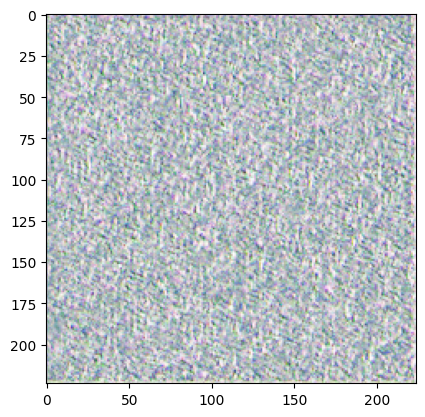

In [32]:
import matplotlib.pyplot as plt

plt.imshow(final.squeeze().permute(1, 2, 0).detach().cpu())

In [ ]:
# # Quick test for random input.
# import matplotlib.pyplot as plt
# out = model(torch.zeros(size=(1, 3, IMG_DIM, IMG_DIM)).to(device))
# plt.imshow(out.squeeze().permute(1, 2, 0).detach().cpu())

Next we create the other modules needed for training, such as the loss measure, and the optimizer.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = BCEDiceLoss()
# WE ARE ONLY INTERESTED IN THE IoU OF THE BLOOD VESSEL CLASS FOR NOW.
benchmark = IoU(class_index=0)

Next, we initialize the trainer and start training. The trainer is responsible for running the training loop, saving checkpoints, and logging metrics 

In [ ]:
BATCH_SIZE = 64

train_loader, test_loader = load_annotated_data(BATCH_SIZE)

In [ ]:
# In addition we want to have a dynamic adjustment of the learning rate.
lr_scheduler = LRScheduler(optimizer, patience=20, min_lr=1e-6, factor=0.8)
# We will ignore the early stopping in this example.

In [ ]:
result = train(
    num_epochs=2,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    benchmark=benchmark,
    checkpoint_name="dpt_trials",
    learning_rate_scheduler=lr_scheduler,
)

Now we can visualize the results.
(*this needs improvements + better and more visualizations for the final paper*)

In [ ]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
from hubmap.visualization import visualize_result

In [ ]:
figures_path = Path().cwd() / "figures"
os.makedirs(figures_path, exist_ok=True)

In [ ]:
loss_fig, benchmark_fig = visualize_result(result)
loss_fig.savefig(Path(figures_path, "dpt_loss.png"))
benchmark_fig.savefig(Path(figures_path, "dpt_benchmark.png"))